# DATA 37712 Final

## In this study, we tried to use the hostorical stock prices and trading volumes to predict the price of next day.

# Testing data and env

In [1]:
!pip install yfinance --upgrade --no-cache-dir



In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt



# API connetion test

[*********************100%***********************]  1 of 1 completed


Historical Stock Data for AMZN
Price           Close       High        Low       Open     Volume
Ticker           AMZN       AMZN       AMZN       AMZN       AMZN
Date                                                             
2019-01-02  76.956497  77.667999  73.046501  73.260002  159662000
2019-01-03  75.014000  76.900002  74.855499  76.000504  139512000
2019-01-04  78.769501  79.699997  75.915497  76.500000  183652000
2019-01-07  81.475502  81.727997  79.459503  80.115501  159864000
2019-01-08  82.829002  83.830498  80.830498  83.234497  177628000


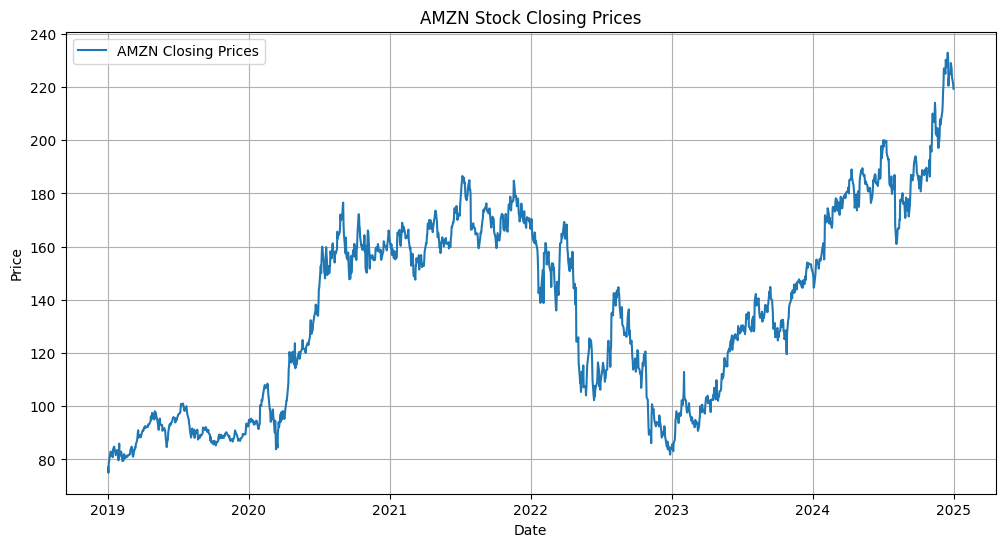

In [3]:
# Set the stock ticker symbol (example: Apple Inc.)
ticker_symbol = "AMZN"

# Download historical stock data for the last 5 years
data = yf.download(ticker_symbol, start="2019-01-01", end="2025-01-01", auto_adjust=True)

# Display the first few rows of the data
print("Historical Stock Data for", ticker_symbol)
print(data.head())

# Plot the stock's closing prices
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label=f'{ticker_symbol} Closing Prices')
plt.title(f'{ticker_symbol} Stock Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

In [25]:
data[0:1]

Price,Close,High,Low,Open,Volume
Ticker,AMZN,AMZN,AMZN,AMZN,AMZN
Date,,,,,
2019-01-02,76.956497,77.667999,73.046501,73.260002,159662000


In [15]:
data[['Close', 'Volume']].to_csv("data.csv")


In [24]:
data_copy = pd.read_csv("data.csv", index_col=0, names=["Close", "Volume"], skiprows=3)
data_copy.head()

,Close,Volume
2019-01-02,76.956497,159662000
2019-01-03,75.014000,139512000
2019-01-04,78.769501,183652000
2019-01-07,81.475502,159864000
2019-01-08,82.829002,177628000


In [ ]:
correlation_matrix = data.corr()
print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
Price             Close      High       Low      Open    Volume
Ticker             AMZN      AMZN      AMZN      AMZN      AMZN
Price  Ticker                                                  
Close  AMZN    1.000000  0.999123  0.999151  0.998064 -0.312088
High   AMZN    0.999123  1.000000  0.998946  0.999213 -0.300475
Low    AMZN    0.999151  0.998946  1.000000  0.999089 -0.324214
Open   AMZN    0.998064  0.999213  0.999089  1.000000 -0.311774
Volume AMZN   -0.312088 -0.300475 -0.324214 -0.311774  1.000000


# load data

In [ ]:
def load_stock_price(ticker: str, start_date: str = '2015-01-01', end_date: str = '2025-01-01'):
    '''
    input:
        tickers, single string of a ticker, like "AAPL"
        start_date: data start
        end_date: data end
    output:

    '''

    # Load Close price and Volume together
    data = yf.download(ticker, start_date, end_date)[['Close', 'Volume']]

    # Fill any missing values if needed
    data = data.ffill()

    # Split into train, validation, and test sets
    train_size = int(len(data) * 0.8)
    val_size = int(len(data) * 0.10)

    train_data = data[:train_size]
    val_data = data[train_size:train_size + val_size]
    test_data = data[train_size + val_size:]

    return train_data, val_data, test_data


# Scaling
- a min-max scaler is used for feature normalization

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def scaling(train_data, val_data , test_data):
    """
    Scales the data using MinMaxScaler and returns scaled data and the scaler.

    Args:
        train_data (np.ndarray): Training data array.
        val_data (np.ndarray): Validation data array.
        test_data (np.ndarray): Test data array.

    Returns:
        tuple: Scaled train, validation, and test datasets along with the scaler instance.
    """
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_train_data = scaler.fit_transform(train_data)
    scaled_val_data = scaler.transform(val_data)
    scaled_test_data = scaler.transform(test_data)

    return scaled_train_data, scaled_val_data, scaled_test_data, scaler

def inverse_scaling(scaler, predicted_prices, test_labels):
    """
    Inverse transforms the predicted prices and test labels using the given scaler.

    Args:
        scaler (MinMaxScaler): Fitted MinMaxScaler instance.
        predicted_prices (list): List of predicted prices from the model.
        test_labels (torch.Tensor): Ground truth labels from the test set.

    Returns:
        tuple: Inverse-transformed predicted and actual prices.
    """

    # Reshape predicted prices to match scaler's input format
    predicted_prices = np.array(predicted_prices).reshape(-1, 1)
    # Create a dummy array with both price and volume
    dummy_input = np.zeros((predicted_prices.shape[0], 2))
    dummy_input[:, 0] = predicted_prices[:, 0]  # Populate the price column
    # Inverse transform
    predicted_prices = scaler.inverse_transform(dummy_input)[:, 0]  # Extract only the price

    # Inverse transform the actual test labels
    test_labels_reshaped = test_labels.cpu().numpy().reshape(-1, 1)
    dummy_actual = np.zeros((test_labels_reshaped.shape[0], 2))
    dummy_actual[:, 0] = test_labels_reshaped[:, 0]

    actual_prices = scaler.inverse_transform(dummy_actual)[:, 0]

    return predicted_prices, actual_prices

# Performance evaluation
- Mean Absolute Error (MAE) and Mean Suqare Error(MSE) are most conceivable metric, which measures the average magnitude of the errors between predicted and actual stock prices without considering their direction.
- Since MAE is affected by the magnitude of targets, the second, Mean Absolute Percentage Error (MAPE) is also going to be used to provide insights into how well the model adapts to fluctuations in stock prices.

In [ ]:

def mean_absolute_percentage_error(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    # Avoid division by zero by filtering out zeros
    non_zero_indices = y_true != 0
    mape = np.mean(np.abs((y_true[non_zero_indices] - y_pred[non_zero_indices]) / y_true[non_zero_indices])) * 100
    return mape

def evaluation(actual_prices, predicted_prices):

    mse = np.mean((np.array(predicted_prices) - np.array(actual_prices)) ** 2)
    mae = np.mean(abs(np.array(predicted_prices) - np.array(actual_prices)))
    mape = mean_absolute_percentage_error(actual_prices, predicted_prices)

    return mse, mae, mape

# A simple LSTM model to predict stock price
- After analysis the correlations between variable, we found that daily open, close, high, and highly correlated. At the end of the day, we decided to choose two variables -- close and volumn, to predict the price stock price of next trainding day.
- The LSTM model use a sequence length of 40 to 60(trading days), which corresponds to roughly two months to three months.
- To mitigate overfitting, AdamW is chosen as optimizer.
- possible improvement: consider date-related strategy, add date variables
    - End-of-Month (EOM) Effect: Stocks tend to rise at the end of the month due to portfolio adjustments.
    - Turn-of-the-Month Effect: Stocks historically perform well in the last few days of a month and the first few days of the next.
    - Day-of-the-Week Effect: Some stocks show patterns like the Monday Effect.


[*********************100%***********************]  1 of 1 completed


Epoch: 0    Train Loss: 0.0370
Epoch: 0    Val Loss: 0.0035
Update the best!
Update the best!
Update the best!
Update the best!
Update the best!
Update the best!
Update the best!
Epoch: 10    Train Loss: 0.0004
Epoch: 10    Val Loss: 0.0005
Update the best!
Update the best!
Epoch: 20    Train Loss: 0.0003
Epoch: 20    Val Loss: 0.0003
Update the best!
Update the best!
Epoch: 30    Train Loss: 0.0002
Epoch: 30    Val Loss: 0.0006
Update the best!
Update the best!
Epoch: 40    Train Loss: 0.0002
Epoch: 40    Val Loss: 0.0019
Update the best!
Epoch: 50    Train Loss: 0.0003
Epoch: 50    Val Loss: 0.0006
Update the best!
Update the best!
Epoch: 60    Train Loss: 0.0002
Epoch: 60    Val Loss: 0.0005
Early stopped!
Loaded the best model state.
LSTM predction of ^GSPC: MSE = 3939.03, MAE = 53.21, MAPE = 0.95


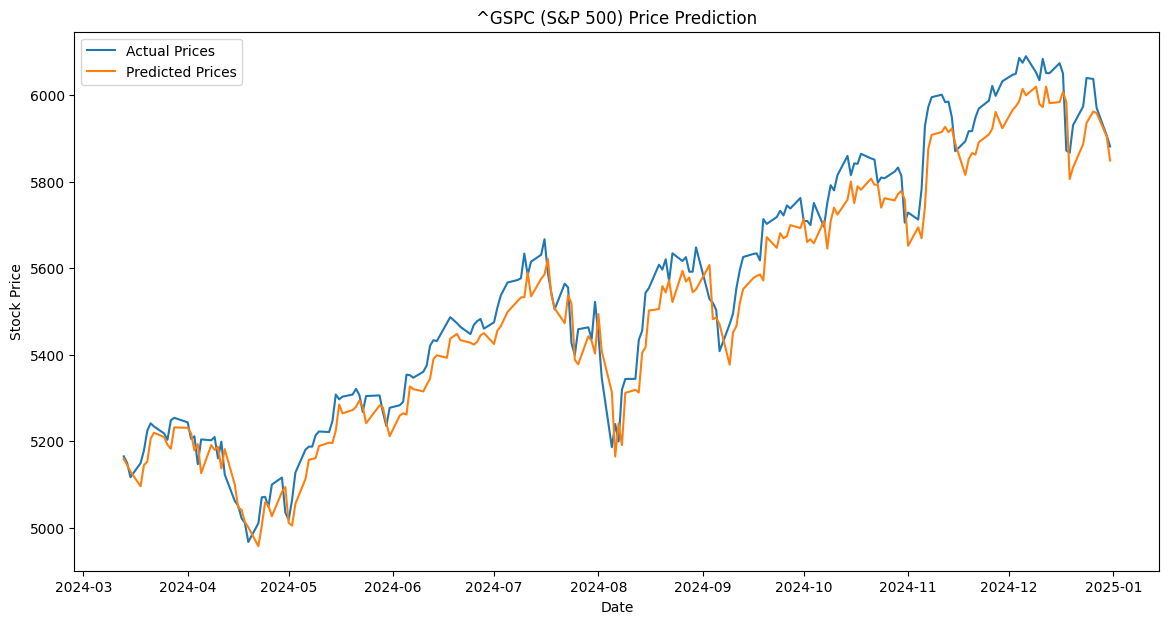

In [ ]:

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import copy
import random

import matplotlib.pyplot as plt


def set_random_seed(seed = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)



DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class MyLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(MyLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # initialize hidden state: (num_layers * num_directions, batch_size, hidden_size)
        # initialize cell state: (num_layers * num_directions, batch_size, hidden_size)
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # input x : (batch_size, seq_length, input_size)
        lstm_out, _ = self.lstm(x, (h_0, c_0))  # (batch_size, seq_length, hidden_size)
        out = self.fc(lstm_out[:, -1, :])  # using the last state in seq_length
        return out

def create_sequences(data: np.ndarray, seq_length: int):
    """
    Create sequences with multiple features and labels for one feature.

    Parameters:
    - data: 2D numpy array of shape (num_samples, num_features)
    - seq_length: Length of each sequence

    Returns:
    - sequences: Numpy array of shape (num_sequences, seq_length, num_features)
    - labels: Numpy array of shape (num_sequences,)
    """
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length, 0])  # Only target price (first feature)
    return np.array(sequences), np.array(labels)



class EarlyStopper:
    def __init__(self, patience: int = 5, min_delta: float = 0.0):
        """
        Early stopping utility to stop training when validation loss stops improving.

        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')

    def should_stop(self, val_loss: float) -> bool:
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1

        return self.counter >= self.patience



def main():

    ticker = "^GSPC"
    train_data, val_data, test_data = load_stock_price(ticker)
    scaled_train_data, scaled_val_data, scaled_test_data, scaler = scaling(train_data, val_data, test_data)


    seq_length = 50  # Example sequence length

    train_sequences, train_labels = create_sequences(scaled_train_data, seq_length)
    val_sequences, val_labels = create_sequences(scaled_val_data, seq_length)
    test_sequences, test_labels = create_sequences(scaled_test_data, seq_length)

    # Convert numpy arrays to PyTorch tensors
    train_sequences = torch.tensor(train_sequences, dtype = torch.float32)
    train_labels = torch.tensor(train_labels, dtype = torch.float32)
    val_sequences = torch.tensor(val_sequences, dtype = torch.float32)
    val_labels = torch.tensor(val_labels, dtype = torch.float32)
    test_sequences = torch.tensor(test_sequences, dtype = torch.float32)
    test_labels = torch.tensor(test_labels, dtype = torch.float32)


    # DataLoader for batching
    batch_size = 64
    train_dataset = TensorDataset(train_sequences, train_labels)
    val_dataset = TensorDataset(val_sequences, val_labels)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)



    input_size = train_sequences.shape[2]
    hidden_size = 64
    num_layers = 2
    output_size = 1

    model = MyLSTM(input_size, hidden_size, output_size, num_layers).to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.005, weight_decay=1e-3)

    # Train the model
    epochs = 100

    early_stopper = EarlyStopper(patience = 10)
    best_val_loss = float('inf')
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X_train, y_train in train_loader:
            X_train, y_train = X_train.to(DEVICE), y_train.to(DEVICE)

            outputs = model(X_train)
            loss = criterion(outputs.squeeze(), y_train)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        avg_train_loss = total_loss / len(train_loader)
        if epoch % 10 == 0:
            print(f"Epoch: {epoch}    Train Loss: {avg_train_loss:.4f}")

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(DEVICE), y_val.to(DEVICE)

                outputs = model(X_val)
                loss = criterion(outputs.squeeze(), y_val)

                val_loss += loss.item()

            avg_val_loss = val_loss / len(val_loader)
            if epoch % 10 == 0:
                print(f"Epoch: {epoch}    Val Loss: {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            print(f"Update the best!")
        if early_stopper.should_stop(avg_val_loss):
            print(f"Early stopped!")
            break
    if best_model_state:
        model.load_state_dict(best_model_state)
        model.to(DEVICE)
        print("Loaded the best model state.")

    # Evaluate the model on test data
    model.eval()

    # Collect predictions on the test set
    predicted_prices = []


    with torch.no_grad():
        for i in range(0, len(test_sequences), batch_size):
            X_test = test_sequences[i:i + batch_size].to(DEVICE)
            batch_outputs = model(X_test).cpu().numpy()
            predicted_prices.extend(batch_outputs.flatten())

    predicted_prices, actual_prices = inverse_scaling(scaler, predicted_prices, test_labels)

    ## Evaluation
    mse, mae, mape = evaluation(actual_prices, predicted_prices)
    print(f'LSTM predction of {ticker}: MSE = {mse:.2f}, MAE = {mae:.2f}, MAPE = {mape:.2f}')


    # Plot the test results
    plt.figure(figsize=(14, 7))
    plt.plot(test_data.index[seq_length:], actual_prices, label='Actual Prices')
    plt.plot(test_data.index[seq_length:], predicted_prices, label='Predicted Prices')
    plt.title(f'{ticker} (S&P 500) Price Prediction')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()


if __name__ == "__main__":
    main()



In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(LSTMModel, self).__init__()

        # Embedding layers for categorical features
        self.month_embed = nn.Embedding(12, 4)   # 12 months → 4-dimensional embeddings
        self.weekday_embed = nn.Embedding(7, 3)  # 7 days → 3-dimensional embeddings

        self.lstm = nn.LSTM(input_dim + 4 + 3, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x, month_idx, weekday_idx):
        month_embedded = self.month_embed(month_idx)
        weekday_embedded = self.weekday_embed(weekday_idx)

        x = torch.cat([x, month_embedded, weekday_embedded], dim=-1)  # Concatenate embeddings
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :])  # Output from the last LSTM step
        return x

# TFT from scratch

In [1]:
from google.colab import files

uploaded = files.upload()

Saving GRN.png to GRN.png


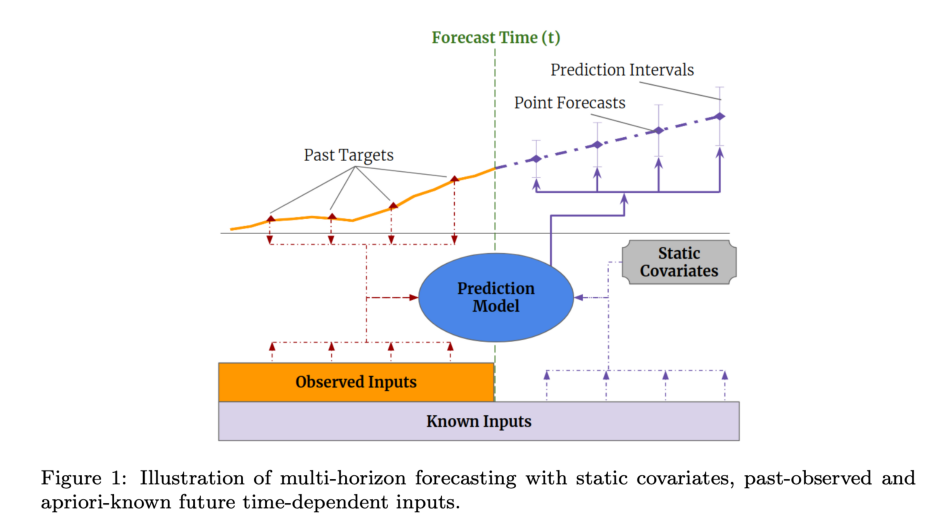

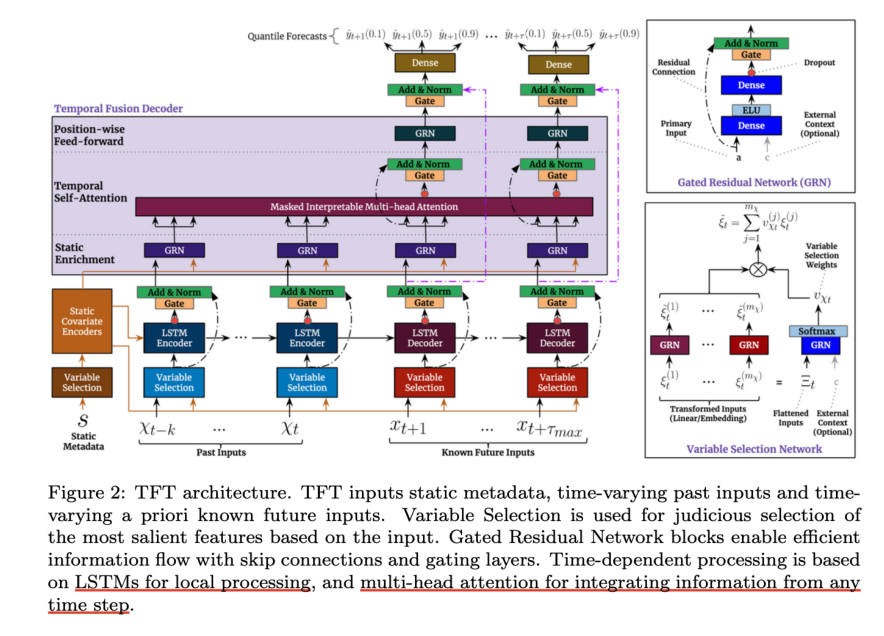

In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Replace 'your_figure.png' with the name of your uploaded file

plt.figure(figsize=(12, 8))  # Adjust figure size
img = mpimg.imread('TFT1.png')
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

plt.figure(figsize=(12, 8))  # Adjust figure size
img = mpimg.imread('TFT2.png')
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

## Analysis of the architecture

### This structure is similar with encoder - decoder transformer

### special features:
- deal with different data sources, as shown in Fig. 1, including known information about the future (e.g. upcoming holiday dates), other exogenous time series (e.g. historical customer foot traffic), and static metadata (e.g. location of the store)
- Since at each time point, data have more than one feature, this model using a v**ariable selection network** to selecting features.
- **Gating mechanisms** to provide adaptive depth and network complexity to accommodate a wide range of datasets and scenarios.
- Try to earn both long- and short-term temporal relationships from both observed and known time-varying inputs. A sequence- to-sequence layer (LSTM) is employed for local processing, whereas long-term depen- dencies are captured using a novel **interpretable multi-head attention block**. (I don't under stand why averaging the output of each head)



## Code of each block

### Data processing
- In order to fit this model, we need to create more features than we used in LSTM model.
- Since we only predict a single stock, no need to put static variable.
- Stock prices and tradding valumes is unseen in future(decoder)
- We add the following known information as candicate features: 'Day_of_Week', 'Day_of_Month', 'Week_of_Year','Month', they can be seen in both encoder and decoder.

In [ ]:
import pandas as pd
def load_stock_price_and_known(ticker: str, start_date: str = '2015-01-01', end_date: str = '2025-01-01'):
    '''
    input:
        tickers, single string of a ticker, like "AAPL"
        start_date: data start
        end_date: data end
    output:

    '''

    # Load Close price and Volume together
    df = yf.download(ticker, start=start_date, end=end_date)

    df[['Close', 'Volume']].to_csv("data.csv")
    df = pd.read_csv("data.csv", index_col=0, names=["Close", "Volume"], skiprows=3)
    df.head()
    # Ensure the index is in datetime format
    df.index = pd.to_datetime(df.index, format="%Y-%m-%d")


    # Extract required columns and create new time-based features
    df_processed = df[['Close', 'Volume']].copy()
    df_processed['Day_of_Week'] = df.index.dayofweek  # Monday = 0, Sunday = 6
    df_processed['Day_of_Month'] = df.index.day
    df_processed['Week_of_Year'] = df.index.isocalendar().week
    df_processed['Week_of_Year'] = df_processed['Week_of_Year'].astype('int32')
    df_processed['Month'] = df.index.month


    # Fill any missing values if needed
    data = df_processed.ffill()

    # Split into train, validation, and test sets
    train_size = int(len(data) * 0.8)
    val_size = int(len(data) * 0.10)

    train_data = data[:train_size]
    val_data = data[train_size:train_size + val_size]
    test_data = data[train_size + val_size:]

    return train_data, val_data, test_data

In [ ]:
def scaling(train_data, val_data , test_data):
    """
    Scales the data using MinMaxScaler and returns scaled data and the scaler.

    Args:
        train_data (np.ndarray): Training data array.
        val_data (np.ndarray): Validation data array.
        test_data (np.ndarray): Test data array.

    Returns:
        tuple: Scaled train, validation, and test datasets along with the scaler instance.
    """
    #scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = StandardScaler()

    # Fit on training data and transform
    train_data_scaled = train_data.copy()
    train_data_scaled[['Close', 'Volume']] = scaler.fit_transform(train_data[['Close', 'Volume']])

    # Transform validation and test data without refitting
    val_data_scaled = val_data.copy()
    val_data_scaled[['Close', 'Volume']] = scaler.fit_transform(val_data[['Close', 'Volume']])

    test_data_scaled = test_data.copy()
    test_data_scaled[['Close', 'Volume']] = scaler.fit_transform(test_data[['Close', 'Volume']])

    return train_data_scaled, val_data_scaled, test_data_scaled, scaler


def inverse_scaling(scaler, predicted_prices, test_labels):
    """
    Inverse transforms the predicted prices and test labels using the given scaler.

    Args:
        scaler (MinMaxScaler): Fitted MinMaxScaler instance.
        predicted_prices (list): List of predicted prices from the model.
        test_labels (torch.Tensor): Ground truth labels from the test set.

    Returns:
        tuple: Inverse-transformed predicted and actual prices.
    """

    # Reshape predicted prices to match scaler's input format
    predicted_prices = np.array(predicted_prices).reshape(-1, 1)
    # Create a dummy array with both price and volume
    dummy_input = np.zeros((predicted_prices.shape[0], 2))
    dummy_input[:, 0] = predicted_prices[:, 0]  # Populate the price column
    # Inverse transform
    predicted_prices = scaler.inverse_transform(dummy_input)[:, 0]  # Extract only the price

    # Inverse transform the actual test labels
    test_labels_reshaped = test_labels.to_numpy().reshape(-1, 1)
    dummy_actual = np.zeros((test_labels_reshaped.shape[0], 2))
    dummy_actual[:, 0] = test_labels_reshaped[:, 0]

    actual_prices = scaler.inverse_transform(dummy_actual)[:, 0]

    return predicted_prices, actual_prices

### New dataset structure for dataloader
- Features have different data types.

In [ ]:
from torch.utils.data import Dataset, DataLoader
class StockDataset(Dataset):
    def __init__(self, df, whole_seq_length=30, decode_length = 1):
        '''
        seq_length: the whole encoder-decoder length
        return: (in our case of one step prediction)
            data: len(data) = seq_length
            labels: len(labels) = 1

        '''
        ##
        self.seq_len = whole_seq_length
        self.decode_len = decode_length
        #self.data = df[['Close', 'Volume', 'Day_of_Week', 'Day_of_Month', 'Week_of_Year', 'Month']].values
        self.data = df[['Close', 'Volume', 'Month']].values
        self.labels = df['Close'].values

    def __len__(self):
        return len(self.data) - self.seq_len + 1

    def __getitem__(self, index):
        x = self.data[index:index + self.seq_len]
        y = self.labels[(index + self.seq_len - self.decode_len):(index + self.seq_len)]

        x_tensor = torch.empty((self.seq_len, x.shape[1]), dtype=torch.float32)
        x_tensor[:, 0:2] = torch.tensor(x[:, 0:2], dtype=torch.float32)  # 'Close' and 'Volume'
        x_tensor[:, 2:] = torch.tensor(x[:, 2:], dtype=torch.int32)  # 'Day_of_Week', 'Day_of_Month', 'Week_of_Year', 'Month'

        # Convert y to a tensor (float64)
        y_tensor = torch.tensor(y, dtype=torch.float32)
        return x_tensor, y_tensor

### Gated Residual Networks (GRN)  
- Controls information flow
- Giving the model the flexibility to apply non-linear processing where needed .


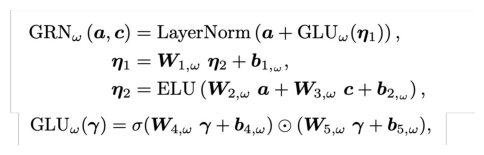

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.figure(figsize=(6, 4))  # Adjust figure size
img = mpimg.imread('GRN.png')
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class GatedLinearUnit(nn.Module):
    """Gated Linear Unit for feature selection and gating mechanisms"""
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.gate = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.fc(x) * torch.sigmoid(self.gate(x))



class GatedResidualNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout, batch_first=False):
        super(GatedResidualNetwork, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        if self.input_dim!=self.output_dim:
            self.skip_layer = nn.Linear(self.input_dim, self.output_dim)

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.elu = nn.ELU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.glu = GatedLinearUnit(output_dim, output_dim) # Use GLU instead of simple linear
        self.norm = nn.LayerNorm(output_dim)   #not sure LayerNorm or BatchNorm1d
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        if self.input_dim!=self.output_dim:   #last dim of x is not the same as output
            res = self.skip_layer(x)  #(len, B, output_dim)
        else:
            res = x
        x = self.fc1(x)     #(len, B, hidden_dim)
        x = self.elu(x)
        x = self.fc2(x)    #(len, B, output_dim)
        x = self.dropout(x)
        x = self.glu(x)  # Apply GLU
        x = x + res  # Residual connection
        return self.norm(x)


### Variable Selection Network
- instance-wise variable selection
- variable representation (turn to TFT class for details):
    - representation for categorical variables: nn.embedding()
    - representation for continuous variables:nn.linear()

In [ ]:
class VSN(nn.Module):
    def __init__(self, input_size, num_inputs, hidden_size, dropout):
        '''
        input_size: generally, concatenatation of variable embddings
        num_inputs: number of variables involved in the input embedddings
        hidden_size: the hidden size of LSTM
        '''
        super(VSN, self).__init__()

        self.hidden_size = hidden_size
        self.input_size =input_size
        self.num_inputs = num_inputs
        self.dropout = dropout

        self.flattened_grn = GatedResidualNetwork(self.num_inputs*self.input_size, self.hidden_size, self.num_inputs, self.dropout)

        self.single_variable_grns = nn.ModuleList()
        for i in range(self.num_inputs):
            self.single_variable_grns.append(GatedResidualNetwork(self.input_size, self.hidden_size, self.hidden_size, self.dropout))

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, embedding):

        sparse_weights = self.flattened_grn(embedding)   #(len, B, num_variables)
        sparse_weights = self.softmax(sparse_weights).unsqueeze(2)  #(len, B, 1, num_variables)

        var_outputs = []
        for i in range(self.num_inputs):    #num_inputs(num_variables) of (len, B, hidden_size)
            var_outputs.append(self.single_variable_grns[i](embedding[:,:, (i*self.input_size) : (i+1)*self.input_size]))

        var_outputs = torch.stack(var_outputs, axis=-1)     # torch.stack along axis=-1 (len, B, hidden_size, num_variables)
        outputs = var_outputs*sparse_weights         # (len, B, hidden_size, num_variables)
        outputs = outputs.sum(axis=-1)   #(len, B, hidden_size)

        return outputs, sparse_weights

### Some utility functions
- Position encoding
- Add and norm block


In [ ]:

class PositionEncoding(nn.Module):
    def __init__(self, hidden_dim, dropout, max_len=1000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.hidden_dim = hidden_dim

        positional_encodings = torch.zeros(max_len, hidden_dim)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, hidden_dim, 2) * (-math.log(10000) / hidden_dim)
        )
        positional_encodings[:, 0::2] = torch.sin(position * div_term)
        positional_encodings[:, 1::2] = torch.cos(position * div_term)
        positional_encodings = positional_encodings.unsqueeze(0)    # (1, max_len, hidden_dim)

        #positional_encodings is stored as part of the model but not updated during training
        self.register_buffer(
            "positional_encodings", positional_encodings, persistent=False
        )

    def forward(self, x):
        x = x * math.sqrt(self.hidden_dim)
        seq_len = x.size(0)
        x = x + self.positional_encodings[:, : seq_len].view(seq_len, 1, self.hidden_dim)
        return self.dropout(x)

class AddNorm(nn.Module):
    def __init__(self, feature_dim, eps=1e-6):
        super(AddNorm, self).__init__()
        self.layer_norm = nn.LayerNorm(feature_dim, eps=eps)

    def forward(self, x, sublayer_output):
        """
        Args:
            x: Tensor of shape (seq_len, batch, feature_dim)
            sublayer_output: Tensor of shape (seq_len, batch, feature_dim)
        Returns:
            Normalized tensor of shape (seq_len, batch, feature_dim)
        """
        return self.layer_norm(x + sublayer_output)


### TFT class (7 blocks in following order)
- Embedding: encoder embedding and decoder embedding
- Variable selection: encoder variable selection and decoder variable selection
- Postion encooding
- LSTM, followed by Gate, Add&Norm
- Encoder-Decoder Attention, followed by Gate, Add&Norm
- Position-wise feed forward, followed by Gate, Add&Norm
- Fully connected output(a linear layer)


In [ ]:
class TFT(nn.Module):
    def __init__(self, config):
        super(TFT, self).__init__()

        self.device = config['device']
        self.batch_size=config['batch_size']

        self.seq_length = config['seq_length']           # whole TS length
        self.encoder_len = config['num_encoder_steps']   #TS length of encoder

        self.num_cat =  config['num_categoical_variables']   #total number of categoical variables/features
        self.cat_embedding_vocab_sizes = config['cat_embedding_vocab_sizes']
        self.num_real_encoder =  config['num_real_encoder'] #number of real variables in encoer
        self.num_real_decoder =  config['num_real_decoder'] #number of real variables in decoer
        self.num_input_to_mask = config['num_masked_vars']  #number of real variables masked in decoder ('Close', 'Volume')
        self.embedding_dim = config['embedding_dim']  #embeddding dim of each variable

        self.hidden_size = config['lstm_hidden_dimension']   #LSTM params
        self.lstm_layers = config['lstm_layers']
        self.dropout = config['dropout']
        self.attn_heads = config['attn_heads']    #attention params
        self.ouput_len = config['ouput_len']


        # Embeddings for categorical variables
        self.cat_embeddings = nn.ModuleList([
            nn.Embedding(num_categories, self.embedding_dim).to(self.device) for num_categories in self.cat_embedding_vocab_sizes
        ])

        # Linear layers for continuous variables
        self.continuous_linear = nn.ModuleList([
            nn.Linear(1, self.embedding_dim).to(self.device) for _ in range(self.num_real_encoder)
        ])

        self.encoder_variable_selection = VSN(self.embedding_dim,
                                (self.num_real_encoder +  self.num_cat),
                                self.hidden_size,
                                self.dropout)

        self.decoder_variable_selection = VSN(self.embedding_dim,
                                (self.num_real_decoder +  self.num_cat),
                                self.hidden_size,
                                self.dropout)

        self.position_encoding = PositionEncoding(self.hidden_size, self.dropout, self.seq_length)

        self.lstm_encoder_input_size = self.embedding_dim*(self.num_real_encoder + self.num_cat)

        self.lstm_decoder_input_size = self.embedding_dim*(self.num_real_decoder + self.num_cat)

        self.lstm_encoder = nn.LSTM(input_size=self.hidden_size,
                            hidden_size=self.hidden_size,
                           num_layers=self.lstm_layers,
                           dropout=self.dropout, batch_first=False)

        self.lstm_decoder = nn.LSTM(input_size=self.hidden_size,
                                   hidden_size=self.hidden_size,
                                   num_layers=self.lstm_layers,
                                   dropout=self.dropout, batch_first=False)

        self.post_lstm_gate = GatedLinearUnit(self.hidden_size, self.hidden_size)
        self.addnorm = AddNorm(self.hidden_size)

        self.multihead_attn = nn.MultiheadAttention(self.hidden_size, self.attn_heads, batch_first=False)

        self.post_attn_gate = GatedLinearUnit(self.hidden_size, self.hidden_size)
        self.attn_dropout = nn.Dropout(self.dropout)
        #self.post_attn_norm = TimeDistribution(nn.BatchNorm1d(self.hidden_size, self.hidden_size))

        self.pos_wise_ff = GatedResidualNetwork(self.hidden_size, self.hidden_size, self.hidden_size, self.dropout)

        #self.pre_output_norm = TimeDistribution(nn.BatchNorm1d(self.hidden_size, self.hidden_size))
        self.pre_output_gate = GatedLinearUnit(self.hidden_size, self.hidden_size)

        self.output_layer = nn.Linear(self.hidden_size, self.ouput_len)

    def apply_embedding(self, x, apply_masking = True):
        '''
            x : (batch_size, timesteps, features)
            features: 'Close','Volume', 'Day_of_Week', 'Day_of_Month', 'Week_of_Year','Month'
           apply_masking: mask variables that should not be accessed after the encoding steps
        '''

        #real variable embeddings  ['Close','Volume']
        if apply_masking:
            time_varying_real_vectors = []
            for i in range(self.num_real_decoder):
                emb = self.continuous_linear[i+self.num_input_to_mask](x[:,:,i+self.num_input_to_mask].view(x.size(0), -1, 1))
                time_varying_real_vectors.append(emb)
            if time_varying_real_vectors == []:
                time_varying_real_embedding = []
            else:
                time_varying_real_embedding = torch.cat(time_varying_real_vectors, dim=2)

        else:
            time_varying_real_vectors = []
            for i in range(self.num_real_encoder):
                emb = self.continuous_linear[i](x[:,:,i].view(x.size(0), -1, 1))  #(B, len, emb_dim)
                time_varying_real_vectors.append(emb)
            time_varying_real_embedding = torch.cat(time_varying_real_vectors, dim=2) #(B, len, emb_dim*num_real)


         ##categorical embeddings ['Day_of_Week', 'Day_of_Month', 'Week_of_Year','Month']
        time_varying_categoical_vectors = []
        for i in range(self.num_cat):
            cat_feature = x[:, :, self.num_real_encoder + i].long()
            emb = self.cat_embeddings[i](cat_feature)
            time_varying_categoical_vectors.append(emb)
        time_varying_categoical_embedding = torch.cat(time_varying_categoical_vectors, dim=2)  #(B, len, emb_dim*num_cat)

        ##concatenate all embeddings  #(B, len, emb_dim*(num_cat + num_real)
        if time_varying_real_embedding == []:
            embeddings = time_varying_categoical_embedding
        else:
            embeddings = torch.cat([time_varying_categoical_embedding,time_varying_real_embedding], dim=2)

        return embeddings.view( -1, x.size(0), embeddings.size(2))

    def init_lstm_hidden(self, bs, hs):
        '''
        initialize hidden state: (num_layers * num_directions, batch_size, hidden_size)
        initialize cell state: (num_layers * num_directions, batch_size, hidden_size)
        num_directions: 1
        '''
        return torch.zeros(self.lstm_layers, bs, hs, device=self.device)

    def encode(self, x, hidden=None):
        if hidden is None:
            hidden = self.init_lstm_hidden(x.shape[1], x.shape[2])
        if x.shape[1] != hidden.shape[1]:
            breakpoint()
        output, (hidden, cell) = self.lstm_encoder(x, (hidden, hidden))
        return output, hidden

    def decode(self, x, hidden=None):
        if hidden is None:
            hidden = self.init_lstm_hidden(x.shape[1], x.shape[2])
        output, (hidden, cell) = self.lstm_decoder(x, (hidden, hidden))
        return output, hidden


    def forward(self, x):
        '''
        x: iunput data, size of (B, seq_len, num_features)
        '''
        #Embedding and variable selection
        embeddings_encoder = self.apply_embedding(x[:,:self.encoder_len,:],apply_masking=False)  #(len, B, emb_dim*(num_cat + num_real))
        embeddings_decoder = self.apply_embedding(x[:,self.encoder_len:,:], apply_masking=True)  #(len, B, emb_dim*(num_cat))
        embeddings_encoder, encoder_sparse_weights = self.encoder_variable_selection(embeddings_encoder)  #(len_encode, B, hidden_dim)
        embeddings_decoder, decoder_sparse_weights = self.decoder_variable_selection(embeddings_decoder)  #(len_decode, B, hidden_dim)

        scale_factor = torch.sqrt(torch.tensor(self.hidden_size, dtype=torch.float, device=embeddings_encoder.device))
        embeddings_encoder = embeddings_encoder * scale_factor  # Scale the embeddings
        embeddings_encoder_pos = self.position_encoding(embeddings_encoder)

        embeddings_decoder = embeddings_decoder * scale_factor  # Scale the embeddings
        embeddings_decoder_pos = self.position_encoding(embeddings_decoder)

         ## LSTM
        lstm_input = torch.cat([embeddings_encoder_pos,embeddings_decoder_pos], dim=0)   #(seq_len, B, hidden_dim)
        encoder_output, hidden = self.encode(embeddings_encoder)
        decoder_output, _ = self.decode(embeddings_decoder, hidden)
        lstm_output = torch.cat([encoder_output, decoder_output], dim=0)

        ## Gate
        lstm_output = self.post_lstm_gate(lstm_output)  #(seq_len, B, hidden_dim)
        ## Add and norm
        attn_input = self.addnorm(lstm_input, lstm_output)   #(seq_len, B, hidden_dim)

        ### Encoder-Decoder Attention
        attn_output, attn_output_weights = self.multihead_attn(
            attn_input[self.encoder_len:,:,:], attn_input[:self.encoder_len,:,:], attn_input[:self.encoder_len,:,:])

        ## Gate
        attn_output = self.post_attn_gate(attn_output)
        ## Add and norm
        attn_output = self.addnorm(attn_input[self.encoder_len:,:,:], attn_output)  #(decode_len, B, hidden_dim)

        ## Position-wise feed forward
        output = self.pos_wise_ff(attn_output)    #(decode_len, B, hidden_dim)

        ## Gate
        output = self.pre_output_gate(output)     #(decode_len, B, hidden_dim)

        # Add and norm
        output = self.addnorm(lstm_output[self.encoder_len:,:,:], output)   #(decode_len, B, hidden_dim)

        # Fully connected output
        bs = output.shape[1]
        output = self.output_layer(output.view(bs, -1, self.hidden_size))   #(B, 1, 1)


        out = output[:, -1, :]
        return out.squeeze()


### A demo

In [ ]:
import random

def set_random_seed(seed = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)



# Hyper pparams
SEQ_LEN = 45
ENCODE_LEN = 44
DECODE_LEN = SEQ_LEN - ENCODE_LEN
BATCH_SIZE = 6
EPOCHS = 200
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


####### params for TFT
config = {}
# params for variables
config['num_categoical_variables'] = 1  # 'Day_of_Week', 'Day_of_Month', 'Week_of_Year','Month'
config['num_real_encoder'] = 2    # 'Close','Volume'
config['num_real_decoder'] = 0
config['num_masked_vars'] = 2    # 'Close','Volume'
#config['cat_embedding_vocab_sizes'] = [8,32,54,13]   # 'Day_of_Week + 1', 'Day_of_Month + 1', 'Week_of_Year + 1','Month + 1'
config['cat_embedding_vocab_sizes'] = [13]   # 'Day_of_Week + 1', 'Month + 1'
config['embedding_dim'] = 3
config['ouput_len'] = 1    # 'Close'

#params for sequence
config['seq_length'] = SEQ_LEN
config['num_encoder_steps'] = ENCODE_LEN

#params for models
config['lstm_hidden_dimension'] = 128
config['lstm_layers'] = 2
config['dropout'] = 0.2
config['device'] = DEVICE
config['batch_size'] = BATCH_SIZE
config['attn_heads'] = 1



def main():

    ticker = "^GSPC"
    train_data, val_data, test_data = load_stock_price_and_known(ticker)
    scaled_train_data, scaled_val_data, scaled_test_data, scaler = scaling(train_data, val_data, test_data)

    train_dataset = StockDataset(scaled_train_data, SEQ_LEN, DECODE_LEN)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    test_dataset = StockDataset(scaled_test_data, SEQ_LEN, DECODE_LEN)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    val_dataset = StockDataset(scaled_val_data, SEQ_LEN, DECODE_LEN)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    model = TFT(config).to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0002, weight_decay=1e-5)

    # Train the model


    early_stopper = EarlyStopper(patience = 20)
    best_val_loss = float('inf')
    best_model_state = None

    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0
        for X_train, y_train in train_loader:
            X_train, y_train = X_train.to(DEVICE), y_train.to(DEVICE)
            train_outputs = model(X_train)
            loss = criterion(train_outputs, y_train.squeeze())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        avg_train_loss = total_loss / len(train_loader)
        if epoch % 5 == 0:
            print(f"Epoch: {epoch}    Train Loss: {avg_train_loss:.4f}")

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(DEVICE), y_val.to(DEVICE)

                outputs = model(X_val)
                loss = criterion(outputs, y_val.squeeze())

                val_loss += loss.item()

            avg_val_loss = val_loss / len(val_loader)
            if epoch % 5 == 0:
                print(f"Epoch: {epoch}    Val Loss: {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            print(f"Update the best!")
        if early_stopper.should_stop(avg_val_loss):
            print(f"Early stopped!")
            break
    if best_model_state:
        model.load_state_dict(best_model_state)
        model.to(DEVICE)
        print("Loaded the best model state.")

    # Evaluate the model on test data
    model.eval()

    # Collect predictions on the test set
    predicted_prices = []

    with torch.no_grad():
        for X_test, _ in test_loader:
            X_test = X_test.to(DEVICE)
            batch_outputs = model(X_test).cpu().numpy()
            predicted_prices.extend(batch_outputs.flatten())



    predicted_prices, actual_prices = inverse_scaling(scaler, predicted_prices, scaled_test_data['Close'][ENCODE_LEN:])

    ## Evaluation
    mse, mae, mape = evaluation(actual_prices, predicted_prices)
    print(f'TFT prediction of {ticker}: MSE = {mse:.2f}, MAE = {mae:.2f}, MAPE = {mape:.2f}')

    # Plot the test results
    plt.figure(figsize=(14, 7))
    plt.plot(test_data.index[ENCODE_LEN:], actual_prices, label='Actual Prices')
    plt.plot(test_data.index[ENCODE_LEN:], predicted_prices, label='Predicted Prices')
    plt.title(f'{ticker} Price Prediction')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.savefig(f"TFT_{ticker}_price_prediction.png", dpi=300, bbox_inches='tight')
    plt.show()

